Here we want to build a model. We decide on building an LSTM for the following reasons: 
- Need to capture long-term information in the model.
- Other model choices would not be appropriate (due to non-staionary time series).
- Complexity of time series can be properly captured.

We will first build a model for all states, then build a model per state.

In [ ]:
import pickle
import polars as pl
import ml_utils
import mlflow
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
import holidays
from sklearn.metrics import mean_absolute_error
import constants

In [2]:
with open('blood_donations.pkl', 'rb') as file:
    df = pickle.load(file)

df.head(8)

date,state,a,b,o,ab,all
date,str,i64,i64,i64,i64,i64
2006-01-01,"""Johor""",19,20,45,3,87
2006-01-02,"""Johor""",4,3,6,2,15
2006-01-03,"""Johor""",2,2,4,0,8
2006-01-04,"""Johor""",7,11,12,3,33
2006-01-05,"""Johor""",3,8,8,1,20
2006-01-06,"""Johor""",2,0,2,0,4
2006-01-07,"""Johor""",1,0,0,0,1
2006-01-08,"""Johor""",20,27,30,9,86


In [3]:
df = df.with_columns([
    pl.col("date").dt.weekday().alias("weekday"),
    pl.col("date").dt.month().alias("month"),
    pl.col("date").dt.ordinal_day().alias("day_of_year")   
])

df.head(8)

date,state,a,b,o,ab,all,weekday,month,day_of_year
date,str,i64,i64,i64,i64,i64,i8,i8,i16
2006-01-01,"""Johor""",19,20,45,3,87,7,1,1
2006-01-02,"""Johor""",4,3,6,2,15,1,1,2
2006-01-03,"""Johor""",2,2,4,0,8,2,1,3
2006-01-04,"""Johor""",7,11,12,3,33,3,1,4
2006-01-05,"""Johor""",3,8,8,1,20,4,1,5
2006-01-06,"""Johor""",2,0,2,0,4,5,1,6
2006-01-07,"""Johor""",1,0,0,0,1,6,1,7
2006-01-08,"""Johor""",20,27,30,9,86,7,1,8


In [4]:
# Starting with all
df_all = df.group_by(['date']).agg([
    pl.sum('all').alias('all'),
    pl.first('weekday').alias('weekday'),
    pl.first('month').alias('month'),
    pl.first('day_of_year').alias('day_of_year')
]).sort('date')

df_all.head(8)

date,all,weekday,month,day_of_year
date,i64,i8,i8,i16
2006-01-01,525,7,1,1
2006-01-02,227,1,1,2
2006-01-03,112,2,1,3
2006-01-04,391,3,1,4
2006-01-05,582,4,1,5
2006-01-06,324,5,1,6
2006-01-07,118,6,1,7
2006-01-08,795,7,1,8


In [5]:
holiday_data = [
    {"date": date, "name": name} for date, name in 
    holidays.country_holidays('MY', years=range(2006, 2026)).items()
]

malaysia_holidays_df = pl.DataFrame(holiday_data).filter(pl.col("name") != "Cuti tambahan sempena memperingati SAT 2017")
malaysia_holidays_df

date,name
date,str
2006-01-29,"""Tahun Baharu Cina"""
2006-01-30,"""Tahun Baharu Cina (Hari Kedua)"""
2006-05-12,"""Hari Wesak"""
2006-05-01,"""Hari Pekerja"""
2006-06-03,"""Hari Keputeraan Rasmi Seri Pad…"
…,…
2025-09-05,"""Hari Keputeraan Nabi Muhammad …"
2025-03-31,"""Hari Raya Puasa"""
2025-04-01,"""Hari Raya Puasa (Hari Kedua)"""


In [6]:
malaysia_holidays_df = malaysia_holidays_df.with_columns(
    pl.col("name").str.replace(r"\s*\(Hari Kedua\)", "").alias("name")
).with_columns(
    pl.col("name").str.replace(r"\s*\(pergantian hari\)", "").alias("name")
).with_columns(
    pl.col("name").str.replace(r"\s*\(pilihan raya umum\)", "").alias("name")
).with_columns(
    pl.col("name").str.replace("Cuti ", "").alias("name")
)

In [7]:
df_all = df_all.join(malaysia_holidays_df, on='date', how='left').fill_null("No holiday")
df_all

date,all,weekday,month,day_of_year,name
date,i64,i8,i8,i16,str
2006-01-01,525,7,1,1,"""No holiday"""
2006-01-02,227,1,1,2,"""No holiday"""
2006-01-03,112,2,1,3,"""No holiday"""
2006-01-04,391,3,1,4,"""No holiday"""
2006-01-05,582,4,1,5,"""No holiday"""
…,…,…,…,…,…
2025-05-12,3178,1,5,132,"""Hari Wesak"""
2025-05-13,1604,2,5,133,"""No holiday"""
2025-05-14,1686,3,5,134,"""No holiday"""


In [8]:
holidays_dummies = df_all.select(pl.col("name").alias("h")).to_dummies()
holidays_dummies.head(5)

h_Awal Muharam,h_Hari Kebangsaan,h_Hari Kebangsaan; Hari Raya Puasa,h_Hari Keputeraan Nabi Muhammad S.A.W.,h_Hari Keputeraan Nabi Muhammad S.A.W.; Hari Malaysia,h_Hari Keputeraan Rasmi Seri Paduka Baginda Yang di-Pertuan Agong,h_Hari Krismas,h_Hari Malaysia,h_Hari Pekerja,h_Hari Pekerja; Hari Wesak,h_Hari Pertabalan Yang di-Pertuan Agong ke-15,h_Hari Pertabalan Yang di-Pertuan Agong ke-16,h_Hari Raya Puasa,h_Hari Raya Qurban,h_Hari Wesak,h_No holiday,h_Peristiwa,h_Tahun Baharu Cina
u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [9]:
df_all = pl.concat([df_all.drop('name'), holidays_dummies], how="horizontal")
df_all.head(5)

date,all,weekday,month,day_of_year,h_Awal Muharam,h_Hari Kebangsaan,h_Hari Kebangsaan; Hari Raya Puasa,h_Hari Keputeraan Nabi Muhammad S.A.W.,h_Hari Keputeraan Nabi Muhammad S.A.W.; Hari Malaysia,h_Hari Keputeraan Rasmi Seri Paduka Baginda Yang di-Pertuan Agong,h_Hari Krismas,h_Hari Malaysia,h_Hari Pekerja,h_Hari Pekerja; Hari Wesak,h_Hari Pertabalan Yang di-Pertuan Agong ke-15,h_Hari Pertabalan Yang di-Pertuan Agong ke-16,h_Hari Raya Puasa,h_Hari Raya Qurban,h_Hari Wesak,h_No holiday,h_Peristiwa,h_Tahun Baharu Cina
date,i64,i8,i8,i16,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
2006-01-01,525,7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2006-01-02,227,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2006-01-03,112,2,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2006-01-04,391,3,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2006-01-05,582,4,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [10]:
def handle_duplicate_holidays(df, double_name, name_1, name_2):
    return df.with_columns(
        (pl.col(name_1) | pl.col(double_name)).alias(name_1),
        (pl.col(name_2) | pl.col(double_name)).alias(name_2)
    ).drop(double_name)

In [11]:
df_all = handle_duplicate_holidays(df_all, 'h_Hari Pekerja; Hari Wesak', 'h_Hari Pekerja', 'h_Hari Wesak')
df_all = handle_duplicate_holidays(df_all, 'h_Hari Keputeraan Nabi Muhammad S.A.W.; Hari Malaysia', 'h_Hari Keputeraan Nabi Muhammad S.A.W.', 'h_Hari Malaysia')
df_all = handle_duplicate_holidays(df_all, 'h_Hari Kebangsaan; Hari Raya Puasa', 'h_Hari Kebangsaan', 'h_Hari Raya Puasa')

df_all = df_all.with_columns(
    (pl.col('h_Hari Pertabalan Yang di-Pertuan Agong ke-15') | pl.col('h_Hari Pertabalan Yang di-Pertuan Agong ke-16')).alias('h_Hari Pertabalan Yang di-Pertuan Agong')
).drop('h_Hari Pertabalan Yang di-Pertuan Agong ke-15', 'h_Hari Pertabalan Yang di-Pertuan Agong ke-16')


In [12]:
df_all = df_all.drop(['h_No holiday'])
df_all.head(5)

date,all,weekday,month,day_of_year,h_Awal Muharam,h_Hari Kebangsaan,h_Hari Keputeraan Nabi Muhammad S.A.W.,h_Hari Keputeraan Rasmi Seri Paduka Baginda Yang di-Pertuan Agong,h_Hari Krismas,h_Hari Malaysia,h_Hari Pekerja,h_Hari Raya Puasa,h_Hari Raya Qurban,h_Hari Wesak,h_Peristiwa,h_Tahun Baharu Cina,h_Hari Pertabalan Yang di-Pertuan Agong
date,i64,i8,i8,i16,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
2006-01-01,525,7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2006-01-02,227,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0
2006-01-03,112,2,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0
2006-01-04,391,3,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0
2006-01-05,582,4,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
religion_or_culture_holidays = [
    'h_Awal Muharam',
    'h_Hari Keputeraan Nabi Muhammad S.A.W.',
    'h_Hari Krismas',
    'h_Tahun Baharu Cina',
]

other_holidays = [
    'h_Hari Kebangsaan',
    'h_Hari Keputeraan Rasmi Seri Paduka Baginda Yang di-Pertuan Agong',
    'h_Peristiwa',
    'h_Hari Pertabalan Yang di-Pertuan Agong'
]

low_donation_holidays = [
    'h_Hari Raya Puasa',
    'h_Hari Raya Qurban',
]

high_donation_holidays = [
    'h_Hari Malaysia',
    'h_Hari Pekerja',
    'h_Hari Wesak',
]

In [14]:
from functools import reduce

df_all = (
    df_all
    .with_columns(
    reduce(
        lambda acc, col: acc | pl.col(col),
        religion_or_culture_holidays[1:],
        pl.col(religion_or_culture_holidays[0])
    ).alias("is_religion_or_culture_holiday"),
    reduce(
        lambda acc, col: acc | pl.col(col),
        other_holidays[1:],
        pl.col(other_holidays[0])
    ).alias("is_other_holiday"),
    reduce(
        lambda acc, col: acc | pl.col(col),
        low_donation_holidays[1:],
        pl.col(low_donation_holidays[0])
    ).alias("is_low_donation_holiday"),
    reduce(
        lambda acc, col: acc | pl.col(col),
        high_donation_holidays[1:],
        pl.col(high_donation_holidays[0])
    ).alias("is_high_donation_holiday")
    )
).drop(
    *religion_or_culture_holidays,
    *other_holidays,
    *low_donation_holidays,
    *high_donation_holidays
)

In [ ]:
for lag in range(1, constants.WINDOW_SIZE+1):
    df_all = df_all.with_columns(
        pl.col("all").shift(lag).alias(f"all_lag_{lag}")
    )

df_all = df_all.drop_nulls()

In [16]:
df_all

date,all,weekday,month,day_of_year,is_religion_or_culture_holiday,is_other_holiday,is_low_donation_holiday,is_high_donation_holiday,all_lag_1,all_lag_2,all_lag_3,all_lag_4,all_lag_5,all_lag_6,all_lag_7
date,i64,i8,i8,i16,u8,u8,u8,u8,i64,i64,i64,i64,i64,i64,i64
2006-01-08,795,7,1,8,0,0,0,0,118,324,582,391,112,227,525
2006-01-09,346,1,1,9,0,0,0,0,795,118,324,582,391,112,227
2006-01-10,2,2,1,10,0,0,1,0,346,795,118,324,582,391,112
2006-01-11,448,3,1,11,0,0,0,0,2,346,795,118,324,582,391
2006-01-12,805,4,1,12,0,0,0,0,448,2,346,795,118,324,582
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-05-12,3178,1,5,132,0,0,0,1,2652,1845,900,1619,1613,1434,1120
2025-05-13,1604,2,5,133,0,0,0,0,3178,2652,1845,900,1619,1613,1434
2025-05-14,1686,3,5,134,0,0,0,0,1604,3178,2652,1845,900,1619,1613


In [ ]:
X_seq = df_all.select([f"all_lag_{lag}" for lag in range(1, constants.WINDOW_SIZE+1)]).to_numpy().reshape(-1, constants.WINDOW_SIZE, 1)
X_features = df_all.select(["weekday", "month", "day_of_year", "is_religion_or_culture_holiday", "is_other_holiday", "is_low_donation_holiday", "is_high_donation_holiday"]).to_numpy()
y = df_all['all'].to_numpy()

In [18]:
# Set up scalers 
from sklearn.preprocessing import RobustScaler

y_scaler = RobustScaler()
X_scaler = RobustScaler()

In [ ]:
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()
X_features_scaled = X_scaler.fit_transform(X_features)
X_seq_scaled = y_scaler.transform(X_seq.reshape(-1, 1)).reshape(-1, constants.WINDOW_SIZE, 1)

In [20]:
import numpy as np

In [ ]:
X_seq_train, X_seq_val, X_seq_test, X_features_train, X_features_val, X_features_test, y_train, y_val, y_test = ml_utils.train_val_split_lstm_feature_data(
    X_seq_scaled,
    X_features_scaled,
    y_scaled,
    constants.TRAIN_FRAC,
    constants.VAL_FRAC
)

In [22]:
experiment_id = ml_utils.get_or_create_mlflow_experiment("NewTest2")

In [23]:
model_type = ["LSTM", "SimpleRNN"]
seq_units = [24, 48, 64]
dense_units = [8, 16]
activation_list = ['mish', 'relu']
optimizer_list = ['adam']
dropout_list = [0.05, 0.1]

In [24]:
for seq_type in model_type:
    for seq_unit in seq_units:
        for dense_unit in dense_units:
            for activation in activation_list:
                for optimizer in optimizer_list:
                    for dropout in dropout_list:
                        print(f"Running {seq_type} experiment with seq_units={seq_unit}, dense_units={dense_unit}, activation={activation}, optimizer={optimizer}, dropout={dropout}.")
                        ml_utils.run_experiment(
                            X_seq_train=X_seq_train, X_features_train=X_features_train, y_train=y_train,
                            X_seq_val=X_seq_val, X_features_val=X_features_val, y_val=y_val,
                            seq_type=seq_type, seq_units=seq_unit, dense_units=dense_unit, activation=activation, dropout=dropout,
                            optimizer=optimizer, experiment_id=experiment_id
                        )

Running LSTM experiment with seq_units=24, dense_units=8, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2104 - mae: 0.3036
Validation Loss: 0.2168281078338623, Validation MAE: 0.31814515590667725
Running LSTM experiment with seq_units=24, dense_units=8, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2113 - mae: 0.3086
Validation Loss: 0.214364692568779, Validation MAE: 0.31911301612854004
Running LSTM experiment with seq_units=24, dense_units=8, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2146 - mae: 0.3011 
Validation Loss: 0.21788673102855682, Validation MAE: 0.3128569722175598
Running LSTM experiment with seq_units=24, dense_units=8, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2059 - mae: 0.2955 
Validation Loss: 0.20679354667663574, Validation MAE: 0.3039924204349518
Running LSTM experiment with seq_units=24, dense_units=16, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2050 - mae: 0.3006
Validation Loss: 0.2151123285293579, Validation MAE: 0.31810814142227173
Running LSTM experiment with seq_units=24, dense_units=16, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2145 - mae: 0.3005
Validation Loss: 0.22247213125228882, Validation MAE: 0.3181782066822052
Running LSTM experiment with seq_units=24, dense_units=16, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1916 - mae: 0.2881 
Validation Loss: 0.19590067863464355, Validation MAE: 0.2972615659236908
Running LSTM experiment with seq_units=24, dense_units=16, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1908 - mae: 0.2917 
Validation Loss: 0.20020711421966553, Validation MAE: 0.3029346764087677
Running LSTM experiment with seq_units=48, dense_units=8, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2258 - mae: 0.3037
Validation Loss: 0.22529104351997375, Validation MAE: 0.3166015148162842
Running LSTM experiment with seq_units=48, dense_units=8, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2170 - mae: 0.3004
Validation Loss: 0.2188350409269333, Validation MAE: 0.31500303745269775
Running LSTM experiment with seq_units=48, dense_units=8, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2084 - mae: 0.3044
Validation Loss: 0.21404311060905457, Validation MAE: 0.314375102519989
Running LSTM experiment with seq_units=48, dense_units=8, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2067 - mae: 0.2999 
Validation Loss: 0.2138649821281433, Validation MAE: 0.31322309374809265
Running LSTM experiment with seq_units=48, dense_units=16, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2156 - mae: 0.3015
Validation Loss: 0.22213691473007202, Validation MAE: 0.31607767939567566
Running LSTM experiment with seq_units=48, dense_units=16, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2245 - mae: 0.3057
Validation Loss: 0.22252683341503143, Validation MAE: 0.317410945892334
Running LSTM experiment with seq_units=48, dense_units=16, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1971 - mae: 0.2960 
Validation Loss: 0.20082077383995056, Validation MAE: 0.3053681254386902
Running LSTM experiment with seq_units=48, dense_units=16, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1932 - mae: 0.2946 
Validation Loss: 0.20011746883392334, Validation MAE: 0.3052523732185364
Running LSTM experiment with seq_units=64, dense_units=8, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2255 - mae: 0.3052
Validation Loss: 0.23013488948345184, Validation MAE: 0.3227282166481018
Running LSTM experiment with seq_units=64, dense_units=8, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2290 - mae: 0.3057
Validation Loss: 0.22752559185028076, Validation MAE: 0.3192918598651886
Running LSTM experiment with seq_units=64, dense_units=8, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1997 - mae: 0.2982
Validation Loss: 0.20562000572681427, Validation MAE: 0.3077816069126129
Running LSTM experiment with seq_units=64, dense_units=8, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1970 - mae: 0.2946 
Validation Loss: 0.20220424234867096, Validation MAE: 0.3035937249660492
Running LSTM experiment with seq_units=64, dense_units=16, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2156 - mae: 0.3013
Validation Loss: 0.21863359212875366, Validation MAE: 0.316324919462204
Running LSTM experiment with seq_units=64, dense_units=16, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.2158 - mae: 0.3018
Validation Loss: 0.2197655588388443, Validation MAE: 0.3160715699195862
Running LSTM experiment with seq_units=64, dense_units=16, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1987 - mae: 0.2950
Validation Loss: 0.20948614180088043, Validation MAE: 0.3071482181549072
Running LSTM experiment with seq_units=64, dense_units=16, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1959 - mae: 0.2990
Validation Loss: 0.2097269594669342, Validation MAE: 0.3126802444458008
Running SimpleRNN experiment with seq_units=24, dense_units=8, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2126 - mae: 0.3048
Validation Loss: 0.21971969306468964, Validation MAE: 0.31553566455841064
Running SimpleRNN experiment with seq_units=24, dense_units=8, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2035 - mae: 0.3039
Validation Loss: 0.2087470442056656, Validation MAE: 0.3136047124862671
Running SimpleRNN experiment with seq_units=24, dense_units=8, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2025 - mae: 0.3052
Validation Loss: 0.20911221206188202, Validation MAE: 0.31392303109169006
Running SimpleRNN experiment with seq_units=24, dense_units=8, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1914 - mae: 0.3051
Validation Loss: 0.21145328879356384, Validation MAE: 0.32060718536376953
Running SimpleRNN experiment with seq_units=24, dense_units=16, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2138 - mae: 0.3006
Validation Loss: 0.20652343332767487, Validation MAE: 0.30315712094306946
Running SimpleRNN experiment with seq_units=24, dense_units=16, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2099 - mae: 0.2980
Validation Loss: 0.2119307667016983, Validation MAE: 0.3065154552459717
Running SimpleRNN experiment with seq_units=24, dense_units=16, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2057 - mae: 0.2948
Validation Loss: 0.20287376642227173, Validation MAE: 0.303485631942749
Running SimpleRNN experiment with seq_units=24, dense_units=16, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2037 - mae: 0.3016
Validation Loss: 0.2082449495792389, Validation MAE: 0.31409063935279846
Running SimpleRNN experiment with seq_units=48, dense_units=8, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2090 - mae: 0.3030 
Validation Loss: 0.21185380220413208, Validation MAE: 0.3128182291984558
Running SimpleRNN experiment with seq_units=48, dense_units=8, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2037 - mae: 0.3016
Validation Loss: 0.2081356793642044, Validation MAE: 0.3092997968196869
Running SimpleRNN experiment with seq_units=48, dense_units=8, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1908 - mae: 0.3030
Validation Loss: 0.20922432839870453, Validation MAE: 0.3158845007419586
Running SimpleRNN experiment with seq_units=48, dense_units=8, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1974 - mae: 0.2993
Validation Loss: 0.2113645076751709, Validation MAE: 0.3137454092502594
Running SimpleRNN experiment with seq_units=48, dense_units=16, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2107 - mae: 0.3055
Validation Loss: 0.2117535024881363, Validation MAE: 0.31242579221725464
Running SimpleRNN experiment with seq_units=48, dense_units=16, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2088 - mae: 0.3042
Validation Loss: 0.209017813205719, Validation MAE: 0.30934837460517883
Running SimpleRNN experiment with seq_units=48, dense_units=16, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1853 - mae: 0.3018
Validation Loss: 0.19790120422840118, Validation MAE: 0.310915470123291
Running SimpleRNN experiment with seq_units=48, dense_units=16, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2028 - mae: 0.3069
Validation Loss: 0.2084212452173233, Validation MAE: 0.3130412995815277
Running SimpleRNN experiment with seq_units=64, dense_units=8, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2160 - mae: 0.3105
Validation Loss: 0.21919508278369904, Validation MAE: 0.31843993067741394
Running SimpleRNN experiment with seq_units=64, dense_units=8, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2115 - mae: 0.3052
Validation Loss: 0.21849194169044495, Validation MAE: 0.3151405453681946
Running SimpleRNN experiment with seq_units=64, dense_units=8, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2124 - mae: 0.3161
Validation Loss: 0.20889556407928467, Validation MAE: 0.322159081697464
Running SimpleRNN experiment with seq_units=64, dense_units=8, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2141 - mae: 0.3095
Validation Loss: 0.21606743335723877, Validation MAE: 0.3160313069820404
Running SimpleRNN experiment with seq_units=64, dense_units=16, activation=mish, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2142 - mae: 0.3107
Validation Loss: 0.22606000304222107, Validation MAE: 0.32230761647224426
Running SimpleRNN experiment with seq_units=64, dense_units=16, activation=mish, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2112 - mae: 0.3049 
Validation Loss: 0.2145773470401764, Validation MAE: 0.31232741475105286
Running SimpleRNN experiment with seq_units=64, dense_units=16, activation=relu, optimizer=adam, dropout=0.05.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2072 - mae: 0.3110 
Validation Loss: 0.2129283994436264, Validation MAE: 0.31701919436454773
Running SimpleRNN experiment with seq_units=64, dense_units=16, activation=relu, optimizer=adam, dropout=0.1.


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2017 - mae: 0.2977 
Validation Loss: 0.20358306169509888, Validation MAE: 0.30908647179603577


In [25]:
model = ml_utils.get_best_model(experiment_id, "metrics.val_mae")

In [26]:
y_pred = y_scaler.inverse_transform(model.predict([X_seq_test, X_features_test]))
y_test_scaled = y_scaler.inverse_transform(y_test.reshape(-1, 1))
mean_absolute_error(y_test_scaled, y_pred)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


250.07602281167473

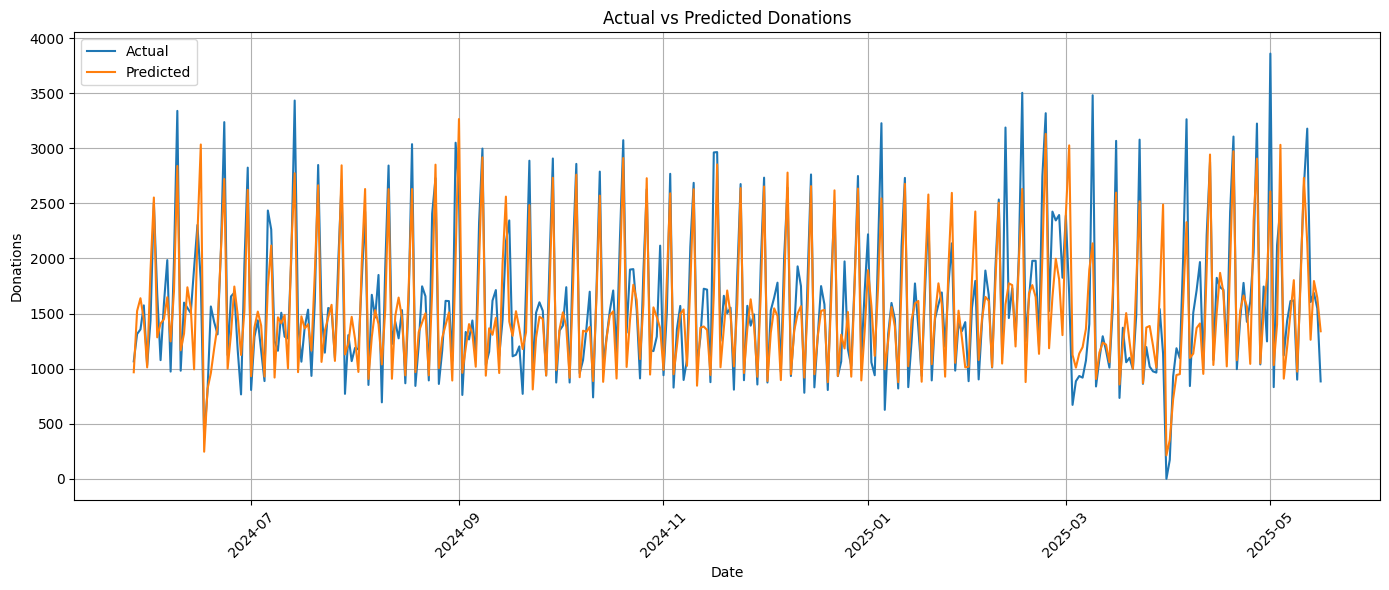

y_true,y_pred,diff,date,abs_diff
f64,f32,f64,date,f64
3188.0,1584.0,1604.0,2025-02-11,1604.0
1136.0,2489.0,-1353.0,2025-03-30,1353.0
1674.0,3026.0,-1352.0,2025-03-02,1352.0
3481.0,2137.0,1344.0,2025-03-09,1344.0
2962.0,1670.0,1292.0,2024-11-16,1292.0
…,…,…,…,…
1010.0,1015.0,-5.0,2025-02-07,5.0
1276.0,1272.0,4.0,2024-10-15,4.0
996.0,998.0,-2.0,2025-03-21,2.0


In [27]:
pred_df = pl.DataFrame({'y_true': y_test_scaled.flatten(), 'y_pred': np.round(y_pred).flatten()})

pred_df = pred_df.with_columns(
    (pl.col('y_true') - pl.col('y_pred')).alias('diff')
).with_columns(
    pl.Series("date", df_all[-pred_df.height:]["date"])
)

pred_df = pred_df.with_columns(
    (abs(pl.col('diff')).alias('abs_diff'))
)

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(pred_df["date"], pred_df["y_true"], label="Actual")
plt.plot(pred_df["date"], pred_df["y_pred"], label="Predicted")
plt.title("Actual vs Predicted Donations")
plt.xlabel("Date")
plt.ylabel("Donations")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

pred_df.sort(by='abs_diff', descending=True)